# Classical RL - Lab 03
> Leigh Goetsch</br>
> Milwaukee School of Engineering</br>
> CSC5661 - Reinforcement Learning</br>
> Fall 2025

In [2]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#In this code we will implement our environments: race and chase
#Jeremy Kedziora
#18 September 2024
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


### Imports

In [3]:
# @@@@@@@@@@@@@@@@@@@@@@@
# import useful libraries
# @@@@@@@@@@@@@@@@@@@@@@@
import numpy as np
import itertools

import copy

import seaborn as sb

from tqdm import tqdm
from IPython.display import clear_output
import time

## Environment Class

In [4]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#two classes for these two environments
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
class race_environment:
    '''A class to manage the race'''
    
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def __init__(self, config):
        '''Set up the constructor
            Takes -- config, a dictionary specifying the track dimensions and initial state
        '''
        self.track = np.zeros((config['track_shape']['height']
                  ,config['track_shape']['width']))    #set up an array to represent the track
        self.track[config['track_shape']['v_track_width']:,config['track_shape']['h_track_width']:] = 1    #block the no-go area
        self.state = {}
        if not config['starting_position']:
            self.state['position'] = {'X':np.random.choice(a = range(config['track_shape']['v_track_width']))
                                      ,'Y':config['track_shape']['height']-1}
        else:
            self.state['position'] = copy.deepcopy(config['starting_position'])
        if not config['starting_velocity']:
            self.state['V'] = {'V':0,'H':0}
        else:
            self.state['V'] = copy.deepcopy(config['starting_velocity'])    #set up the state -- here it will be position and velocity
        self.old_position = copy.deepcopy(self.state['position'])
        self.config = config        
        
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def reset(self):
        '''A function to reset to initial conditions'''
        self.state = {'position':{'X':np.random.choice(a = range(self.config['track_shape']['v_track_width']))
                                      ,'Y':self.config['track_shape']['height']-1}
                      ,'V':{'V':0,'H':0}}    #set up the state -- here it will be position and velocity
        self.old_position = copy.deepcopy(self.state['position'])

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    def update_V(self,a):
        '''A function to update vert and horiz velocity
            Takes -- a, a dictionary containing the vert and horiz acceleration
        '''
        self.state['V']['V'] = min(5,max(0,self.state['V']['V'] + a['V']))    #update the vert velocity
        self.state['V']['H'] = min(5,self.state['V']['H'] + a['H'])    #update the horiz velocity

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    def update_Position(self):
        '''A function to update vert and horiz position
        '''        
        self.state['position']['X'] = self.state['position']['X'] + self.state['V']['H']    #update the horiz position
        self.state['position']['Y'] = self.state['position']['Y'] - self.state['V']['V']    #update the vert position

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    def obstacle_check(self):
        '''A function to check if the player crosses an obstacle'''
        crash = False
        if self.state['position']['X'] != self.old_position['X']:
            m = (self.state['position']['Y'] - self.old_position['Y'])/(self.state['position']['X'] - self.old_position['X'])
            b = self.state['position']['Y'] - m*self.state['position']['X']
            xs = np.linspace(start = self.old_position['X']
                        ,stop = self.state['position']['X']
                        ,num = 2*abs(self.state['position']['X'] - self.old_position['X']) + 1)
            ys = np.round(m*xs + b)
            xs = np.round(xs)
            for x,y in zip(xs,ys):

                if self.track[int(y),int(x)] == 1:
                    crash = True
                    break
        else:
            if self.track[self.state['position']['Y'],self.state['position']['X']] == 1:    #and if the agent is in the no-go
                crash = True    #set crash to true
        return crash

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    def check_crash(self):
        '''A function to check if the agent crashed'''
        crash = False
        if self.state['position']['X'] < 0:    #if the agent goes out of bounds to the left
            crash = True    #set crash to true
        if self.state['position']['Y'] < 0:    #if the agent goes out of bounds to the top
            crash = True    #set crash to true
        if self.state['position']['X'] >= 0 and self.state['position']['X'] < self.config['track_shape']['width']-1 and self.state['position']['Y'] >= 0:    #if the agent is within the array
            crash = self.obstacle_check()
        return crash

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def check_win(self):
        '''A function to check if the agent won'''
        win = False    #assume no win
        if self.state['position']['X'] >= self.config['track_shape']['width'] and self.state['position']['Y'] < self.config['track_shape']['h_track_width']:    #if the agent is over the finish line
            win = True    #set win to true
        return win

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def reward(self,sp):
        return 1/max(1,((sp['X'] - (self.config['track_shape']['width'] - 1))**2
                          + (self.config['track_shape']['h_track_width']/2.0 - sp['Y'])**2))
        
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def step(self,a):
        '''A function to evolve the environment
            Takes -- a, a dictionary containing the vert and horiz acceleration
        '''
        outcome = ''    #track crash/win
        done = False    #set the done indicator
        self.update_V(a)    #update the velocity
        self.update_Position()    #update the position
        crash = self.check_crash()    #check if the agent crashed
        self.old_position = copy.deepcopy(self.state['position'])
        r = self.reward(self.state['position'])
        if crash:
            outcome = 'crash'
        if not crash:    #if the agent didn't crash...
            win = self.check_win()    #check if the agent won
            if win:
                outcome = 'won'
                done = True
                r = 10
        return {'state':self.state
                     ,'reward':r
                     ,'done':done
                    ,'Win/Lost':outcome}


## Agent Classes

In [17]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# two classes for these two environments
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
class agent:
    """A class to manage the agent"""

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def __init__(self, config: dict):
        """Set up the constructor
        Takes -- config, a dictionary specifying the track dimensions and initial state
        """

        self.config: dict = config
        self.epsilon: float = config["epsilon"] if "epsilon" in config else 0.1
        self.gamma: float = config["gamma"] if "gamma" in config else 0.9
        self.A: list[tuple[int, int]] = (
            config["A"]
            if "A" in config
            else list(itertools.product([-1, 0, 1], [-1, 0, 1]))
        )

    def _get_state_key(self, state) -> str:
        """A function to convert the state into a string key for Q-table indexing
        Takes -- state, the current state
        Returns -- key, a string representation of the state
        """
        return f"{state['position']['X']}_{state['position']['Y']}_{state['V']['V']}_{state['V']['H']}"

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def update_Q(self, trajectory) -> None:
        """
        A function to update Q-values
        Takes -- trajectory, a list of state, action, reward tuples
        """
        pass

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def pi(self, state, epsilon) -> tuple[int, int]:
        """
        A function to select an action based on the current policy
        Takes -- state, the current state
                 epsilon, the exploration rate
        Returns -- action, the selected action
        """
        a = np.random.choice(len(self.A))
        return self.A[a]

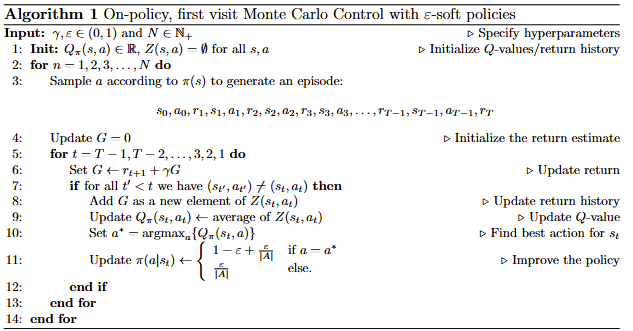

In [ ]:
class Monte_Carlo_agent(agent):
    """A class to manage a random agent"""

    def __init__(self, config):
        """Set up the constructor
        Takes -- config, a dictionary specifying the track dimensions and initial state
        """
        super().__init__(config)

    def update_Q(self, trajectory) -> None:
        """
        A function to update Q-values
        Takes -- trajectory, a list of state, action, reward tuples
        """
        pass

    def pi(self, state, epsilon) -> tuple[int, int]:
        """
        A function to select an action based on the current policy
        Takes -- state, the current state
                 epsilon, the exploration rate
        Returns -- action, the selected action
        """
        return super().pi(state, epsilon)

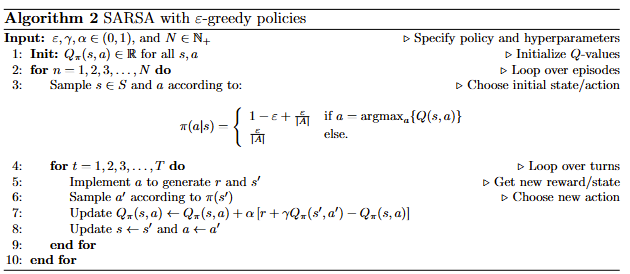

In [ ]:
class SARSA_agent(agent):
    """A class to manage the SARSA agent"""

    def __init__(self, config):
        """Set up the constructor
        Takes -- config, a dictionary specifying the track dimensions and initial state
        """
        super().__init__(config)

    def update_Q(self, trajectory) -> None:
        """
        A function to update Q-values
        Takes -- trajectory, a list of state, action, reward tuples
        """
        pass

    def pi(self, state, epsilon) -> tuple[int, int]:
        """
        A function to select an action based on the current policy
        Takes -- state, the current state
                 epsilon, the exploration rate
        Returns -- action, the selected action
        """
        return super().pi(state, epsilon)

## Learn about the environment
1. Set up the environment class by specifying the appropriate dictionary. 


In [6]:
#@@@@@@@@@@@@@@@@@@@@@@@
#Set up the environments
#@@@@@@@@@@@@@@@@@@@@@@@
height = 30    #set track height
width = 25    #set track width
v_track_width = 10    #set road width for the vert section
h_track_width = 10    #set road width for the horiz section
env_config = {'track_shape':{'height':height
                              ,'width':width
                              ,'v_track_width':v_track_width
                              ,'h_track_width':h_track_width}
          ,'starting_position':None
         ,'starting_velocity':None}    #set up the config for the environment

agent_config = {'epsilon':0.1,'gamma':0.9,'A':list(itertools.product([-1,0,1],[-1,0,1]))}    #set up the config for the agent

renv = race_environment(env_config)    #set up the environment


2. Experiment with this modified racetrack by running the step function. Simulate 100
races with randomly generated values for a (this will be different from the last lab
because the environment has been modified)

In [ ]:
rand_agent = agent(agent_config)  # set up the random agent

crashes = 0
wins = 0
for i in range(100):
    done = False
    renv.reset()
    local_crashes = 0
    while not done:
        a = rand_agent.pi(renv.state, agent_config["epsilon"])
        step_output = renv.step({"V": a[0], "H": a[1]})
        outcome = step_output["Win/Lost"]
        if outcome == "crash":
            local_crashes += 1
            crashes += 1
        if outcome == "won":
            wins += 1
        # added a condition to prevent infinite loops of crashing
        done = step_output["done"] or local_crashes > 500
print(f"Crashes: {crashes}, Wins: {wins}")

Crashes: 1683, Wins: 29


## Solving Markov Decision Problems via Monte Carlo & SARSA

1. Decide how you will represent the state information. Remember – this will be the only
information that the agent has available to make decisions.
2. Decide how you will reward the agent. The goal of the agent is to reach to finish line
without crashing and you need a reward function, r(s′,a,s), to incentivize the agent
to do this.
3. Implement an agent capable of taking actions in this environment by writing python
code to execute the following algorithms. Train the agent by running these algorithms
for an “appropriate” number of episodes (likely no more than 10,000)